# Task 1

`predictive_maintenance_dataset.csv` is a file that contains parameters and settings (`operational_setting_1`, `operational_setting_2`, `sensor_measurement_1`, `sensor_measurement_2`, etc.) for many wind turbines. There is a column called `unit_number` which specifies which turbine it is, and one called `status`, in which a value of 1 means the turbine broke down that day, and 0 means it didn't. Your task is to create a model that, when fed with operational settings and sensor measurements (`unit_number` and `time_stamp` will *not* be fed in), outputs 1 if the turbine will break down within the next 40 days, and 0 if not.

## Ideas


1. **Feature engineering** -- create a column that says `possible_failure`, and mark it as 1 if there is failure within a 40 day window prior to the current observation for a turbine. This might make it easy to predict if the model might fail within 40 days.
1. LSTM using keras
2. Basic multi-label ensemble models using sci-kit learn  (https://arxiv.org/pdf/1609.08349.pdf) - Explore hamming distance to evaluate models and scikit learn functions (http://scikit.ml/api/classify.html#ensemble-approaches)
2. Survival analysis - Kaplan meir estimates

## Assumptions
1. For few turbines there are readings beyond today's date (18th July 2018). For the interest of this analysis, I am going to assume these are valid readings
2. Dealing with NAs in the dataset - Mean value imputation?
2. Date range isn't continuous. **Should I assume that the unit does not fail in that period, or, should I be ignoring the gap in the range of days? (right censored data)**
4. If the window length of 40 isn't satisfied, is padding with 0's the best approach?
3. Dataset is imbalanced. Not certain if creating a balanced set is the best approach in this case. Might end up losing information from sensor data when I try undersampling, and oversampling will cause sensor value distribution to become skewed. Maybe trying ensemble might help (explore if you have time)

## Yet to do

1. Mean value imputation for missing values
2. More hyperparameter optimization

## Importing libraries and dataset

In [135]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from time import time

# scikit learn models
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

import imblearn.over_sampling as oversample

#keras models
import keras
from keras.layers import *
from keras.models import *
from keras.optimizers import *
%matplotlib inline

In [2]:
os.getcwd()
# define path to save model
model_path = 'task1_pm_model.h5'

In [3]:
pm_data = pd.read_csv('../data/predictive_maintenance_dataset.csv')
print(pm_data.shape)
pm_data.head()

(144203, 27)


,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,540,2017-02-19 12:00:00,0,42.0007,0.8415,High,445.00,NaN,1362.47,1143.17,...,133.75,2388.50,8129.92,9.1182,NaN,332.0,2212.0,100.00,10.77,6.5717
1,396,2017-11-21 12:00:00,0,-0.0023,0.0004,High,518.67,642.33,1581.03,1400.06,...,522.19,2388.00,8135.70,8.3817,0.03,393.0,2388.0,100.00,39.07,23.3958
2,513,2017-02-12 12:00:00,0,NaN,0.6216,Low,462.54,536.71,1250.87,1037.52,...,163.11,2028.06,7867.90,10.8827,NaN,306.0,1915.0,84.93,14.33,8.6202
3,211,2014-06-05 12:00:00,0,42.0006,NaN,High,NaN,549.28,1349.42,1114.02,...,130.58,2387.71,8074.81,9.3776,0.02,NaN,2212.0,100.00,10.60,6.2614
4,460,2014-11-27 12:00:00,0,-0.0016,0.0004,High,518.67,643.84,1604.53,1431.41,...,519.44,2388.24,8135.95,8.5223,0.03,396.0,2388.0,100.00,38.39,23.0682


In [4]:
pm_data.isnull().sum(axis=0)

unit_number                 0
time_stamp                  0
status                      0
operational_setting_1    7141
operational_setting_2    7196
operational_setting_3    7227
sensor_measurement_1     7209
sensor_measurement_2     7198
sensor_measurement_3     7190
sensor_measurement_4     7335
sensor_measurement_5     7244
sensor_measurement_6     7444
sensor_measurement_7     7213
sensor_measurement_8     7276
sensor_measurement_9     7207
sensor_measurement_10    7191
sensor_measurement_11    7180
sensor_measurement_12    7227
sensor_measurement_13    7115
sensor_measurement_14    7068
sensor_measurement_15    7257
sensor_measurement_16    7059
sensor_measurement_17    7167
sensor_measurement_18    7265
sensor_measurement_19    7195
sensor_measurement_20    7018
sensor_measurement_21    7165
dtype: int64

In [5]:
# removing NAs drastically drops count. Try imputation with mean value of sensor
# check if operation needs to be performed. Losing out on valuable information
pm_data.dropna(inplace = True)
pm_data.shape

(42076, 27)

In [6]:
# check if dataset is imbalanced
pm_data.dropna(inplace=True)
pm_data.status.value_counts()

0    41880
1      196
Name: status, dtype: int64

## Feature engineering

#### Calculate lag dates

In [7]:
pm_data['time_stamp'] = pd.to_datetime(pm_data.time_stamp)
pm_data.sort_values(['unit_number','time_stamp'], inplace=True)
pm_data.reset_index(inplace=True)

In [8]:
# feature engineering of categorical variable
pm_data = pd.concat([pm_data.drop('operational_setting_3', axis = 1),
                    pd.get_dummies(pm_data.operational_setting_3,
                                   prefix = 'operational_setting_3')[['operational_setting_3_High']]],
                    axis = 1).drop('index', axis = 1)

In [9]:
# take 2 dates and compute the difference
pm_data.sort_values(['unit_number','time_stamp'], inplace=True)
def get_date(date):
    
    date1 = date['time_stamp']
    date2 = date['time_stamp_lag']
    
    # first day
    if str(date2) == 'NaT':
        return 1
    
    # change of year
    if date1 < date2:
        return (date1 + 365) - date2
    
    return (date1 - date2).days

In [10]:
# record observation count for each sensor
pm_data = pd.concat([pm_data,
                     pd.DataFrame(pm_data.groupby('unit_number').cumcount(), columns = ['obs_count'])]
                    , axis = 1)

In [11]:
# create lag dates
lag_dates = (pm_data[['unit_number','time_stamp']]
             .groupby('unit_number')
             .shift(1))
lag_dates = pm_data.join(lag_dates.rename(columns=lambda x: x+"_lag"))

# compute difference in days
time_diff = pd.DataFrame(lag_dates[['time_stamp','time_stamp_lag']].apply(get_date, axis = 1),
                         columns = ['obs_date'])

# append lag_dates to actual data
pm_data = pd.concat([pm_data, time_diff], axis = 1)

In [12]:
pm_final = pd.concat([
            (pm_data[['unit_number','time_stamp','obs_date']]
            .groupby(['unit_number','time_stamp'])
            .sum()
            .groupby(level=[0])
            .cumsum()
            .reset_index()[['obs_date']]),
            pm_data.rename(columns = {'obs_date':'date_bw_obs'}).reset_index().drop('index', axis = 1)
          ], axis = 1
         )
pm_final.head(13)

,obs_date,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,operational_setting_3_High,obs_count,date_bw_obs
0,1,2,2017-04-01 12:00:00,0,-0.0018,0.0006,518.67,641.89,1583.84,1391.28,...,8.3905,0.03,391.0,2388.0,100.0,38.94,23.4585,1,0,1
1,3,2,2017-04-03 12:00:00,0,0.0018,0.0003,518.67,641.55,1588.32,1398.96,...,8.3802,0.03,391.0,2388.0,100.0,39.11,23.4250,1,1,2
2,4,2,2017-04-04 12:00:00,0,0.0035,-0.0004,518.67,641.68,1584.15,1396.08,...,8.4018,0.03,391.0,2388.0,100.0,39.13,23.5027,1,2,1
3,9,2,2017-04-09 12:00:00,0,0.0017,-0.0004,518.67,641.98,1581.99,1395.01,...,8.3868,0.03,390.0,2388.0,100.0,39.06,23.4875,1,3,5
4,11,2,2017-04-11 12:00:00,0,0.0006,0.0004,518.67,642.26,1589.21,1401.29,...,8.4188,0.03,392.0,2388.0,100.0,39.23,23.3888,1,4,2
5,16,2,2017-04-16 12:00:00,0,-0.0010,0.0003,518.67,641.81,1581.99,1393.46,...,8.3805,0.03,392.0,2388.0,100.0,39.01,23.4462,1,5,5
6,20,2,2017-04-20 12:00:00,0,0.0042,-0.0004,518.67,642.34,1582.94,1394.38,...,8.3698,0.03,391.0,2388.0,100.0,39.02,23.3821,1,6,4
7,21,2,2017-04-21 12:00:00,0,-0.0023,0.0001,518.67,642.05,1579.51,1392.28,...,8.3954,0.03,391.0,2388.0,100.0,39.24,23.5014,1,7,1
8,23,2,2017-04-23 12:00:00,0,-0.0013,0.0003,518.67,642.37,1580.89,1387.50,...,8.3937,0.03,393.0,2388.0,100.0,39.10,23.2867,1,8,2
9,24,2,2017-04-24 12:00:00,0,-0.0019,-0.0000,518.67,641.99,1580.97,1398.67,...,8.3866,0.03,391.0,2388.0,100.0,39.18,23.3981,1,9,1


#### Generate label `status_within_40days`

In [13]:
# Check if there is a better method to generate this label..3 loops seems like overkill!
# Sample case: pm_final[pm_final.unit_number == 4]
window_size = 40
Status = [] # hold status
for i,j in pm_final[['unit_number','obs_date','status']].groupby('unit_number'):

    status = j['status'].values # store status for every turbine
    date_bw_obs = j['obs_date'].values # store observed date for a reading
    failure_status = status.copy() # update to 1 if it obs has occured within 40 days of failure
    failures = np.where(status)[0].tolist() # retrieve position of status = 1
    
    if any(failures):
        # in case of multiple failures, loop through all failures. set indicator of last failure and only 
        # start from there. Avoid overlapping!
        for i in failures:
            # Loop through dates between observations to check if it falls within 40 days of failure. 
            for date in range(min(i,window_size)):
                    if (date_bw_obs[i] - date_bw_obs[i - date]) < window_size:
                        failure_status[i - date] = 1
            
    Status = Status + failure_status.tolist()

In [14]:
pm_final['status_within_40'] = Status
pm_final.head()

,obs_date,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,operational_setting_3_High,obs_count,date_bw_obs,status_within_40
0,1,2,2017-04-01 12:00:00,0,-0.0018,0.0006,518.67,641.89,1583.84,1391.28,...,0.03,391.0,2388.0,100.0,38.94,23.4585,1,0,1,0
1,3,2,2017-04-03 12:00:00,0,0.0018,0.0003,518.67,641.55,1588.32,1398.96,...,0.03,391.0,2388.0,100.0,39.11,23.4250,1,1,2,0
2,4,2,2017-04-04 12:00:00,0,0.0035,-0.0004,518.67,641.68,1584.15,1396.08,...,0.03,391.0,2388.0,100.0,39.13,23.5027,1,2,1,0
3,9,2,2017-04-09 12:00:00,0,0.0017,-0.0004,518.67,641.98,1581.99,1395.01,...,0.03,390.0,2388.0,100.0,39.06,23.4875,1,3,5,0
4,11,2,2017-04-11 12:00:00,0,0.0006,0.0004,518.67,642.26,1589.21,1401.29,...,0.03,392.0,2388.0,100.0,39.23,23.3888,1,4,2,0


## Feature scaling

In [15]:
# pick the feature columns 
source = ['operational', 'sensor']
target = list(pm_final.columns)
feature_names = [colname for colname in target 
                    if any(i in colname for i in source)] # check if there is a better way of doing this

scaling_features = feature_names.copy()
if 'operational_setting_3_High' in scaling_features: scaling_features.remove('operational_setting_3_High')

unscaled_features = [col for col in target if col not in scaling_features + ['status','status_within_40']]
print(scaling_features)
print()
print(unscaled_features)
        
stdsc = StandardScaler() # fit this on training data when encountered

['operational_setting_1', 'operational_setting_2', 'sensor_measurement_1', 'sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_5', 'sensor_measurement_6', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_10', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_16', 'sensor_measurement_17', 'sensor_measurement_18', 'sensor_measurement_19', 'sensor_measurement_20', 'sensor_measurement_21']

['obs_date', 'unit_number', 'time_stamp', 'operational_setting_3_High', 'obs_count', 'date_bw_obs']


## Basic EDA

Text(0.5,1,'Pairwise correlation')

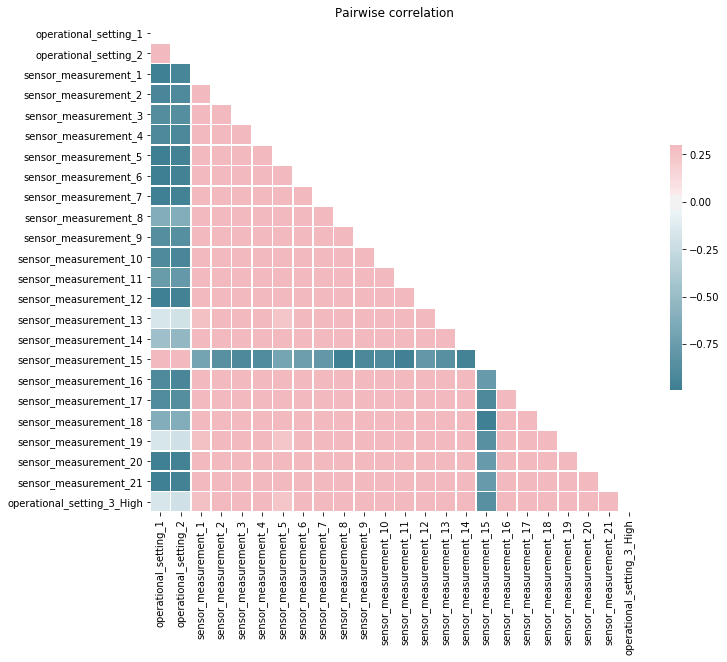

In [16]:
# source for code: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
d = pm_final.loc[:,feature_names]
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title('Pairwise correlation')

Text(0.5,1,'Gap between observations for failure event')

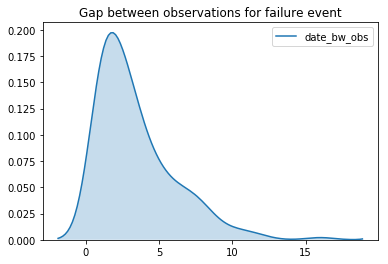

In [17]:
(sns.kdeplot(pm_final.date_bw_obs[pm_final.status == 1], shade = True)
    .set_title('Gap between observations for failure event')
)

Text(0.5,1,'Distribution of cumulative date for readings')

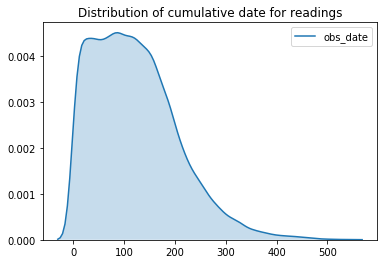

In [18]:
(sns.kdeplot(pm_final['obs_date'], shade=True)
    .set_title("Distribution of cumulative date for readings")
)

Text(0.5,1,'Distribution of reading counts for turbines')

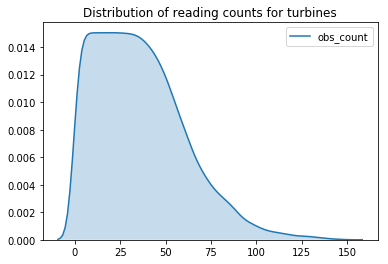

In [19]:
(sns.kdeplot(pm_final['obs_count'], shade=True)
   .set_title("Distribution of reading counts for turbines")
)

In [20]:
pm_final[(pm_final.obs_date < 40) & (pm_final.status == 1)]

,obs_date,unit_number,time_stamp,status,operational_setting_1,operational_setting_2,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,...,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,operational_setting_3_High,obs_count,date_bw_obs,status_within_40


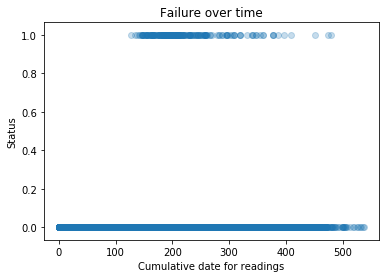

In [21]:
plt.scatter("obs_date","status", data=pm_final,marker='o', alpha = 0.25)
plt.xlabel("Cumulative date for readings")
plt.ylabel("Status")
plt.title('Failure over time')
plt.show()

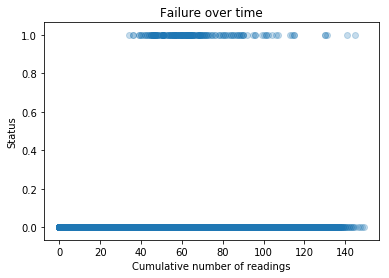

In [22]:
plt.scatter("obs_count","status", data=pm_final,marker='o', alpha = 0.25)
plt.xlabel("Cumulative number of readings")
plt.ylabel("Status")
plt.title('Failure over time')
plt.show()

### Findings
1. From the `Pairwise correlation` graph, there seems to be high correlation with sensor measurement 15 and the other sensor values
2. Operation setting 1 and 2 seem to be correlated with all the sensor values as well. Might be expected as these settings could probably influence sensor readings.
3. From the `gap between observations for failure` graph we notice that usually a sensor fails within 5 days of the previous measurement of the sensor. This seems to follow a Poisson distribution as well
4. The `Failure Over time` graph suggests that all failures occur 100 days after the first measurement was recorded, and most of them fail within 100-300 days of the first reading of the sensor.

**In this case, failure to predict a status of 1 could be detrimental. Hence trying to design a model with a high Recall score (false positives)**

# Should I be balancing the set? -- maybe later

In [23]:
from imblearn.over_sampling import SMOTE

In [24]:
# # Apply SMOTE's
# X = pm_data.drop('time_stamp', axis = 1)
# y = np.asarray(pm_data.drop('time_stamp', axis = 1)['status'])
# kind = 'regular'
# sm = SMOTE(kind='regular')
# #X.shape
# X_res, y_res = sm.fit_sample(X, y)
# X_res.shape

In [25]:
# pm_bal = pd.DataFrame(X_res, columns= pm_data.drop(['time_stamp'], axis = 1).columns)
# pm_bal[['status','unit_number']].groupby('status').agg('count')

## Dataset for model selection

1. For LSTM, create a 3d array for the input - (samples x window_size x features) and a 2d array for the label
2. For other ensemble models, check if using `status_within_40` or creating a sequence of `status` yields better results

In [145]:
# Make a train/test split using 20% test size
X_train_valid, X_test, y_train_valid, y_test = train_test_split(pm_final.drop(['status','status_within_40','time_stamp'], axis = 1)
                                                    ,pm_final[['status']],
                                                    test_size=0.20)

In [160]:
# Balance dataset
sm=oversample.SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_sample(X_train_valid, y_train_valid.values.ravel())
X_resampled = pd.DataFrame(X_resampled, columns=X_train_valid.columns)
y_resampled = pd.DataFrame(y_resampled, columns=y_train_valid.columns)
X_resampled.shape

(67030, 28)

In [161]:
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled
                                                    , y_resampled
                                                    , test_size=0.20)

In [102]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(26928, 29)
(6732, 29)
(8416, 29)


In [103]:
print(y_train.status.value_counts())
print(y_valid.status.value_counts())
print(y_test.status.value_counts())

0    26802
1      126
Name: status, dtype: int64
0    6695
1      37
Name: status, dtype: int64
0    8383
1      33
Name: status, dtype: int64


In [104]:
def bind_scaled_non_scaled(data, scaled_feat, unscaled_feat, model):
    """
    This function scales numeric features and binds other features to the matrix
    
    Args:
        data: Features and label data
        scaled_feat: Feature column names to be scaled
        unscaled_feat: Columns which do not have to be scaled 
        model: Method to be used for scaling numeric values (default is Standard scaler)
    
    Output:
        bind_data: pandas dataframe
            Data frame consisting of scaled and unscaled features for model
    
    """
   
    scaled_data = model.transform(data.loc[:,scaled_feat])
    bind_data =  pd.concat([pd.DataFrame(scaled_data, columns = scaled_feat), 
                            data.loc[:,unscaled_feat].reset_index().drop(data.loc[:,unscaled_feat].columns[0], axis = 1)],
                           axis = 1
                          )
    return bind_data

In [105]:
stdsc.fit(X_train.loc[:,scaling_features])

X_train = bind_scaled_non_scaled(X_train, scaling_features, unscaled_features, stdsc)
X_valid = bind_scaled_non_scaled(X_valid, scaling_features, unscaled_features, stdsc)
X_test = bind_scaled_non_scaled(X_test, scaling_features, unscaled_features, stdsc)

In [106]:
def make_y_series(data, groupby_col, target_col, window_size):
    """
    This function creates a 40 window time sequence of labels (status). Pads with 0s if length < window_size
    
    Args:
        data: input dataset
        groupby_col: Column to group by labels
        target_col: Label column
        window_size: Size of time series window
    
    Output:
        Y: numpy 2d matrix
            Matrix consisting of time series labels for each observation
    
    """
    Y = []
    
    # loop through each turbine data and append next 40 values
    for unit, value in data[[groupby_col,target_col]].groupby(groupby_col):
        data = value.status.values.tolist()
        
        for i in range(len(data)):
            Y_blocks = data[i: i + window_size]

            if len(Y_blocks) < window_size: # if the next 40 values aren't present, pad with 0s. Check if this approach is the best?
                Y_blocks[len(Y_blocks):(window_size - 1)] = [0] * (window_size - len(Y_blocks))
            Y.append(Y_blocks)

    return np.array(Y)

In [107]:
Y = make_y_series(pm_final, 'unit_number', 'status', 40)
Y.shape

(42076, 40)

## Fit LSTM with a 40 layer output to predict the failure event for the next 40 days

LSTM design
1. Input dim -- input shape is equal to the window size and features(24) for this window size(40).
2. Output dim -- probabilities of failure for 40 future days. If prob > 0.5 it can classified as 1 else 0.

In [108]:
# slide a window of 40 and capture feature and status information
# do this for total number of rows in data - size of window(40)
# check if this should be done, or the window itself has to move by 40 per iteration
def pre_process_data_LSTM(data, feature_columns, target_label, window_size, resample = False):
    X,Y = [],[]
#     data = data.reset_index()
    for i in range(data.shape[0]-window_size-1): 
        X_block = np.array(data.loc[i:(i+window_size-1),feature_columns])
        Y_block = np.array(data.loc[i:(i+window_size-1),target_label])
        
        if X_block.shape[1] < (window_size - 1):
            X_block[X_block.shape[1]:window_size-1] = 0
            Y_block[X_block.shape[1]:window_size-1] = 0

        X.append(X_block)
        Y.append(Y_block)
    return np.array(X),np.array(Y)

In [164]:
window_size = 40
t0 = time()

X_tr_ls, y_tr_ls = pre_process_data_LSTM(pd.concat([X_train.reset_index(drop = True),
                                                      y_train.reset_index(drop = True)], axis = 1), 
                                                     feature_names,
                                                     'status',
                                                     window_size)
X_val_ls, y_val_ls = pre_process_data_LSTM(pd.concat([X_valid.reset_index(drop = True),
                                                      y_valid.reset_index(drop = True)], axis = 1), 
                                                     feature_names,
                                                     'status',
                                                     window_size)
X_test_ls, y_test_ls = pre_process_data_LSTM(pd.concat([X_test.reset_index(drop = True),
                                                      y_test.reset_index(drop = True)], axis = 1), 
                                                     feature_names,
                                                     'status',
                                                     window_size)
print("time taken:", (time() - t0))

time taken: 95.20971131324768


In [165]:
print("Shape of input",X_tr_ls.shape)
print("Shape of output",y_tr_ls.shape)

Shape of input (53583, 40, 24)
Shape of output (53583, 40)


In [170]:
# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
# precision and recall were removed from keras, here's the commit https://github.com/keras-team/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [114]:
#https://stackoverflow.com/questions/45411902/how-to-use-f1-score-with-keras-model

In [175]:
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
t0 = time()
nb_features = X_tr_ls.shape[2]
nb_out = y_tr_ls.shape[1]
window_size = 40

model = Sequential()

model.add(LSTM(
         input_shape=(window_size, nb_features),
         units=50,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall,precision,auc_roc])

print(model.summary())

# fit the network
X_tr_val = np.concatenate((X_tr_ls,X_val_ls), axis = 0)
y_tr_val = np.concatenate((y_tr_ls,y_val_ls), axis = 0)

model.fit(X_tr_val, y_tr_val, epochs=10, batch_size=500, verbose=1, validation_split = 0.15, 
          callbacks = [keras.callbacks.EarlyStopping(monitor='recall', patience=5, verbose=1, mode='max')]
          )

print("Total time to run model", (time() - t0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 40, 50)            15000     
_________________________________________________________________
dropout_29 (Dropout)         (None, 40, 50)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_30 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 40)                2040      
Total params: 37,240
Trainable params: 37,240
Non-trainable params: 0
_________________________________________________________________
None
Train on 56905 samples, validate on 10043 samples
Epoch 1/10
56905/56905 [==============================] - 78s 1ms/step - loss: 0.50

In [190]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("../models/model_Task1_LSTM.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../models/model_Task1_LSTM.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

In [186]:
preds = model.predict(X_tr_val)

preds[preds>=0.5] = 1
preds[preds<0.5] = 0

np.mean(preds == y_tr_val)

0.687504481089801

## Trying Linear models, trees...

For `status_within_40` try Basic linear models/trees

Try balancing dataset using undersampling,oversampling and both. Then try fitting the models again

In [23]:
# Make a train/test split using 20% test size
X_train_valid, X_test, y_train_valid_40, y_test_40 = train_test_split(pm_final.drop(['status','status_within_40'], axis = 1)
                                                    ,pm_final[['status_within_40']],
                                                    test_size=0.20)

In [24]:
X_train, X_valid, y_train_40, y_valid_40 = train_test_split(X_train_valid
                                                    , y_train_valid_40
                                                    , test_size=0.20)

In [25]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(26928, 29)
(6732, 29)
(8416, 29)


In [26]:
X_tr = X_train.loc[:,feature_names]
X_val = X_valid.loc[:,feature_names]
X_te = X_test.loc[:,feature_names]
y_tr = np.array(y_train_40.iloc[:,0])
y_val = np.array(y_valid_40.iloc[:,0])
y_te = np.array(y_test_40.iloc[:,0])

In [28]:
names = ["Nearest Neighbors", "Linear SVC", "Decision Tree", 
         "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "XG Boost"]

In [29]:
classifiers = [
    KNeighborsClassifier(n_neighbors= 3,n_jobs= -1),
    LinearSVC(C=0.02, class_weight='balanced'),
    DecisionTreeClassifier(max_depth=7, class_weight='balanced'),
    RandomForestClassifier(max_depth=10, n_estimators=20, max_features=1, class_weight='balanced'),
    MLPClassifier(hidden_layer_sizes = (50,100,100),activation = 'logistic', alpha=0.01),
    AdaBoostClassifier(algorithm="SAMME"),
    GaussianNB(),
    XGBClassifier(max_depth=10,min_child_weight=1, gamma=0, scale_pos_weight=1,objective= 'binary:logistic')]

In [41]:
import warnings
warnings.filterwarnings('ignore')
for name, clf in zip(names, classifiers):
    clf.fit(X_tr, y_train_40)
    y_pred = clf.predict(X_val)
    print('Model name:', name)
    target_names = ['Running', 'Failure']
    print(classification_report(y_valid_40, y_pred, target_names=target_names))

Model name: Nearest Neighbors
             precision    recall  f1-score   support

    Running       0.95      0.99      0.97      6354
    Failure       0.46      0.20      0.28       378

avg / total       0.93      0.94      0.93      6732

Model name: Linear SVM
             precision    recall  f1-score   support

    Running       0.99      0.72      0.84      6354
    Failure       0.16      0.90      0.28       378

avg / total       0.95      0.73      0.81      6732

Model name: Decision Tree
             precision    recall  f1-score   support

    Running       0.98      0.86      0.92      6354
    Failure       0.24      0.76      0.37       378

avg / total       0.94      0.85      0.89      6732

Model name: Random Forest
             precision    recall  f1-score   support

    Running       0.99      0.87      0.93      6354
    Failure       0.27      0.81      0.41       378

avg / total       0.95      0.87      0.90      6732

Model name: Neural Net
            

### Findings

- All the models seem to perform poorly while predicting the failure class (low F1-score). I'm confident that this has to do with the imbalanced dataset. Try proceeding with Random forest after balancing the classes. Linear SVM and Random forest with `class_weights` parameter seems to yield a **high Recall**, at the cost of precision. This is better than the other models
- Random forest without balancing classes yields an average F1-score of `.45`

In [63]:
val_scores=[]
for trees in range(5,35,5):
    print("Fitting...")
    print("iter", trees//5)
    clf = RandomForestClassifier(max_depth=15, 
                                 n_estimators= trees,
                                 class_weight='balanced')
    validated = cross_val_score(clf, 
                                X_train_valid.loc[:,feature_names],
                                y_train_valid_40, 
                                cv = 10, 
                                scoring = 'f1')
    val_scores.append(validated)

Fitting...
iter 1
Fitting...
iter 2
Fitting...
iter 3
Fitting...
iter 4
Fitting...
iter 5
Fitting...
iter 6


In [65]:
val_scores = pd.DataFrame(val_scores, index= [i for i in range(5,35,5)] )

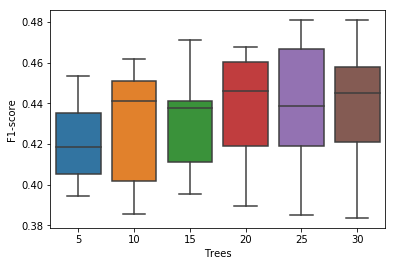

In [66]:
ax = sns.boxplot(data = val_scores.T)
ax.set(xlabel='Trees', ylabel='F1-score')
plt.show()

### Using a balanced dataset

In [68]:
# source: http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/evaluation/plot_classification_report.html#sphx-glr-auto-examples-evaluation-plot-classification-report-py

In [29]:
from imblearn import over_sampling as os
from imblearn.under_sampling import (ClusterCentroids, RandomUnderSampler,
                                     NearMiss,
                                     InstanceHardnessThreshold,
                                     CondensedNearestNeighbour,
                                     EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours,
                                     AllKNN,
                                     NeighbourhoodCleaningRule,
                                     OneSidedSelection)
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

In [73]:
RANDOM_STATE = 1234
from time import time
samplers = [RandomUnderSampler,
             NearMiss,
             InstanceHardnessThreshold,
             EditedNearestNeighbours,
             OneSidedSelection]

for sampler in samplers:
    t0 = time()
    print("Using " + str(sampler))
    sampler = sampler(random_state= RANDOM_STATE)
    clf = pl.make_pipeline(sampler, 
                           LogisticRegression(random_state=RANDOM_STATE))
    clf.fit(X_tr, y_tr)
    
    print("Predicting for " + str(sampler))
    # Test the classifier and get the prediction
    y_pred_val = clf.predict(X_val)

    # Show the classification report
    print(classification_report_imbalanced(y_val, y_pred_val))
    print("Time elapsed:", (time() - t0))

print("Completed evaluation")

Using <class 'imblearn.under_sampling.prototype_selection.random_under_sampler.RandomUnderSampler'>
Predicting for RandomUnderSampler(random_state=1234, ratio='auto', replacement=False,
          return_indices=False)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.83      0.88      0.90      0.86      0.73      6354
          1       0.24      0.88      0.83      0.37      0.86      0.74       378

avg / total       0.95      0.83      0.88      0.87      0.86      0.73      6732

Time elapsed: 0.15831232070922852
Using <class 'imblearn.under_sampling.prototype_selection.nearmiss.NearMiss'>
Predicting for NearMiss(n_jobs=1, n_neighbors=3, n_neighbors_ver3=3, random_state=1234,
     ratio='auto', return_indices=False, size_ngh=None, ver3_samp_ngh=None,
     version=1)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.63      0.70      0.76      0.67      0.4

/home/mojo/anaconda3/lib/python3.6/site-packages/imblearn/under_sampling/prototype_selection/one_sided_selection.py:197: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  idx_maj_extracted = np.delete(idx_maj, idx_maj_sample, axis=0)


Predicting for OneSidedSelection(n_jobs=1, n_neighbors=None, n_seeds_S=1, random_state=1234,
         ratio='auto', return_indices=False, size_ngh=None)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.98      0.22      0.97      0.46      0.23      6354
          1       0.44      0.22      0.98      0.29      0.46      0.20       378

avg / total       0.93      0.94      0.26      0.93      0.46      0.23      6732

Time elapsed: 2.461308002471924
Completed evaluation


**Achieved highest recall and F1-score using Random under sampling** 

In [70]:
RANDOM_STATE = 1234
t0 = time()
print("Using " + str(sampler))
sampler =os.SMOTE(random_state=RANDOM_STATE)
clf = pl.make_pipeline(sampler, 
                       LogisticRegression(random_state=RANDOM_STATE))
clf.fit(X_tr, y_tr)

print("Predicting for " + str(sampler))
# Test the classifier and get the prediction
y_pred_bal =clf.predict(X_val)

# Show the classification report
print(classification_report_imbalanced(y_val, y_pred_bal))
print("Time elapsed:", (time() - t0))

Using SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=1234, ratio='auto', svm_estimator=None)
Predicting for SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=1234, ratio='auto', svm_estimator=None)
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.85      0.85      0.91      0.85      0.72      6354
          1       0.25      0.85      0.85      0.39      0.85      0.73       378

avg / total       0.95      0.85      0.85      0.88      0.85      0.72      6732

Time elapsed: 3.657618284225464


**Achieved a recall of 0.85 and f-1 score of 0.4 on the validation set using Over-sampling**